## Оценка различий линеаризированными методами 

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from scipy import stats
import plotly.express as px
import numpy as np
from scipy import stats
import datetime
from datetime import timedelta
from datetime import datetime as dt
import requests
from urllib.parse import urlencode
from tqdm.auto import tqdm
from scipy.stats import norm
import pandahouse as ph

In [2]:
#выставим настройки графика
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
#создаем подключение
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230520',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
#зададим функция для формирования колонки линейного ctr в датафрейме
def lin_ctr(data, k, t):
        sum_ctr = data[data['exp_group'] == k].likes.sum()/data[data['exp_group'] == k].views.sum()
        data['line_ctr'] = data['likes'] - sum_ctr * data['views']
        return data

---
Сделаем выгрузки по группе 0 и 3

---

In [5]:
#делаем выгрузку
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
3,10049,10049,10049,10049


In [6]:
df_line_ctr_0_3 = lin_ctr(df, 0, 3)

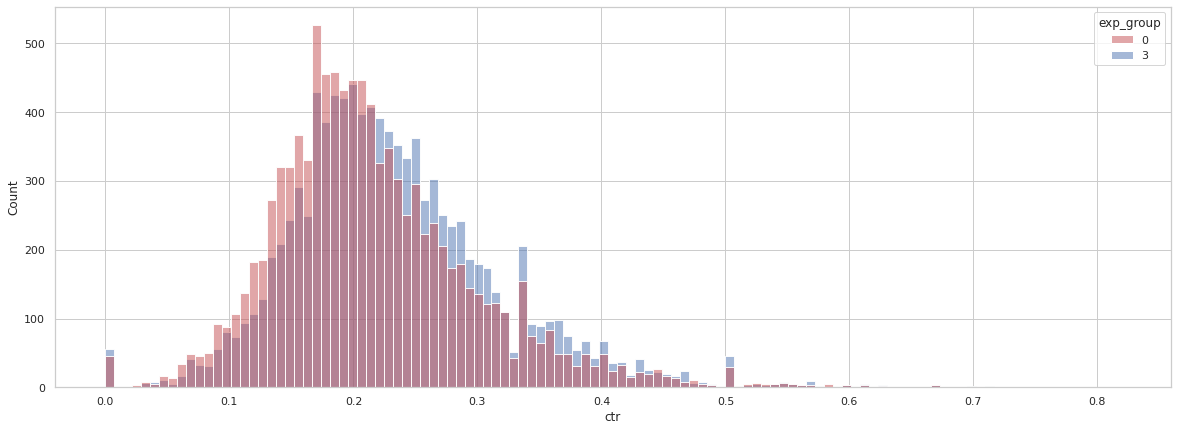

In [7]:
#посмотрим распределение обычного ctr
groups = sns.histplot(data = df_line_ctr_0_3, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

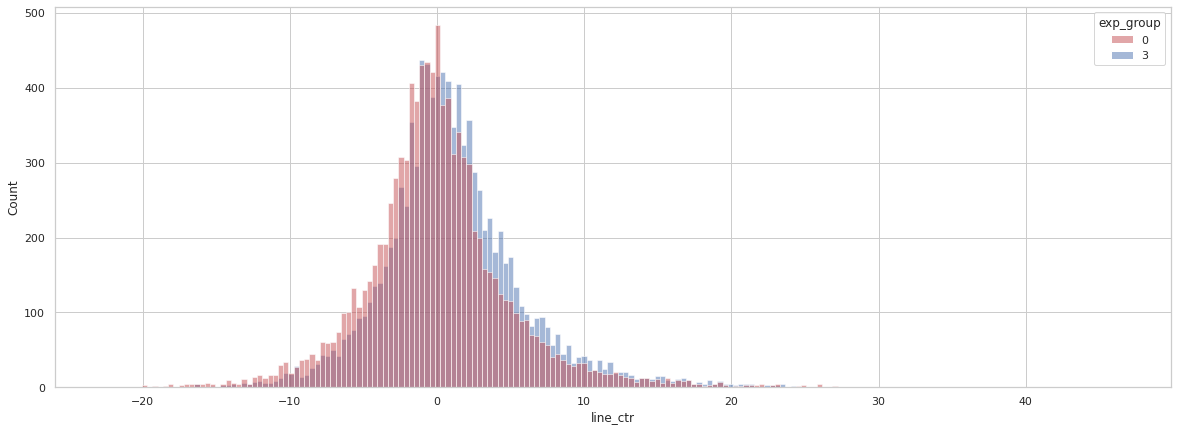

In [8]:
#посмотрим распределение обычного линейного ctr
groups = sns.histplot(data = df_line_ctr_0_3, 
              x='line_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

---
Сравнимым линейный ctr двух групп

---

In [9]:
stats.ttest_ind(df_line_ctr_0_3.query('exp_group == 0').line_ctr,
                df_line_ctr_0_3.query('exp_group == 3').line_ctr, equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

---
Дополнительно сравним обычный ctr t-тестом

---

In [10]:
stats.ttest_ind(df_line_ctr_0_3.query('exp_group == 0').ctr,
                df_line_ctr_0_3.query('exp_group == 3').ctr, equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

---
Сделаем выгрузки по группе 1 и 2

---

In [11]:
#делаем выгрузку
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [12]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


In [13]:
def lin_ctr(data, k, t):
        sum_ctr = data[data['exp_group'] == k].likes.sum()/data[data['exp_group'] == k].views.sum()
        data['line_ctr'] = data['likes'] - sum_ctr * data['views']
        return data

In [14]:
df_line_ctr_1_2 = lin_ctr(df, 1, 2)

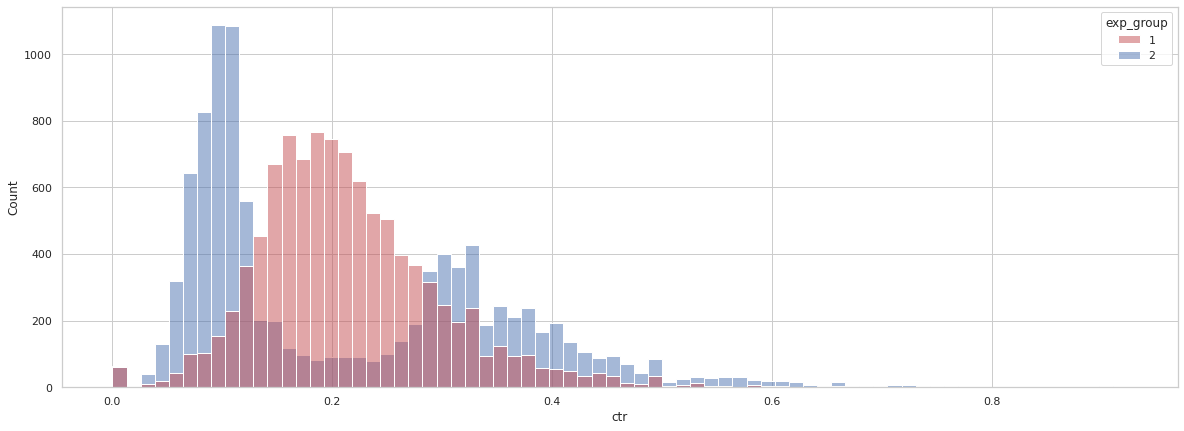

In [15]:
groups = sns.histplot(data = df_line_ctr_1_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

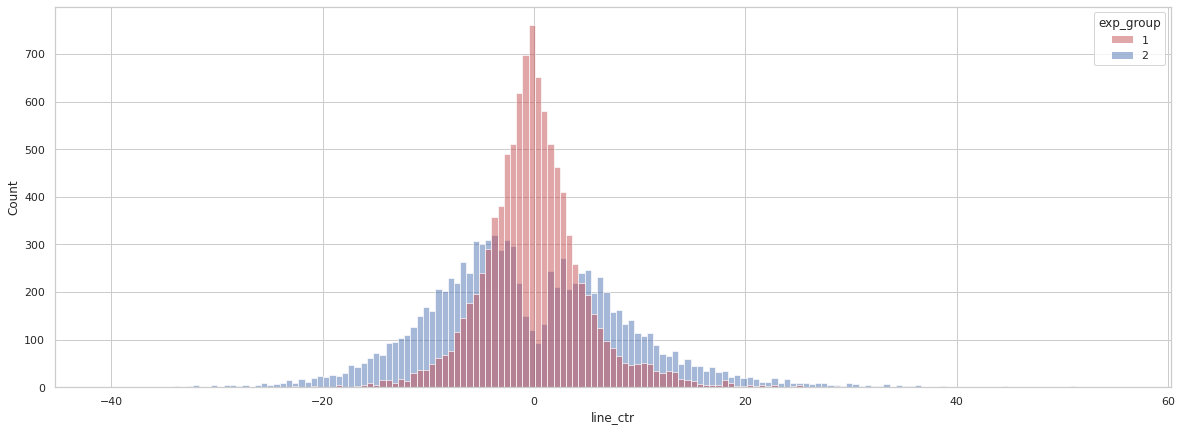

In [16]:
groups = sns.histplot(data = df_line_ctr_1_2, 
              x='line_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

---
Сравнимым линейный ctr двух групп

---

In [17]:
stats.ttest_ind(df_line_ctr_1_2.query('exp_group == 1').line_ctr,
                df_line_ctr_1_2.query('exp_group == 2').line_ctr, equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

---
Дополнительно сравним обычный ctr t-тестом

---

In [18]:
stats.ttest_ind(df_line_ctr_1_2.query('exp_group == 1').ctr,
                df_line_ctr_1_2.query('exp_group == 2').ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

> ## Вывод:
1. В результате сравнения групп 0 и 3 мы получили статзначимые различия как t-тесте так и в t-тесте с линеаризированными ctr. Однако чувствительность AB теста стала выше, потому что pvalue в тесте с линеаризированными ctr меньше обычного.
2. При сравнении групп 1 и 2 мы увидели, что t-test на обычных ctr вообще не показал статзначимости. Скорее всего это вызвано тем, что распределение ctr в экспериментальной группе бимодальное. В то же время тест на линеаризированных ctr показал, что выборки различаются между собой статзначимо.